In [1]:
# import the nessessary packages
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import polars as pl
import plotly.graph_objects as go
from models.ecoli.analysis import variantAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader

In [2]:
# todo for this notebook:
# 1. make a plotly version of these graphing functions (and run Mica's function on the proteins that deviate the most from the line)
# 2. decide if I should maybe make the lines a different color from the scatter data colors to differenciate them better

In [3]:
# work with the filterd data from saved_data_ng_internal_shift1: 
os.chdir(os.path.expanduser('~/wcEcoli/out/sherlock_data/saved_data_ng_internal_shift1/filtered_data/'))

# work specifically with the log data for the second sherlock run 
name_front = 'Filtered_AvgProteinCounts_Variant_'
name_back = '_startGen_14.csv'
variant_info = pd.read_excel('~/wcEcoli/out/sherlock_data/saved_data_ng_internal_shift1/sherlock_sim1_info.xlsx')

# access the unfiltered protein counts too so that the total PC divisor can be calculated: 
unfiltered_pth = '~/wcEcoli/out/sherlock_data/saved_data_ng_internal_shift1/unfiltered_data/'
name_front_unfiltered = 'AvgProteinCounts_Variant_'

# define function that creates a sting with the experimental variant's info
def get_sim1_var_info(var_num):
    # extract the information for a specific variant: 
    variant = variant_info[var_num:var_num+1]
    EI = variant["NG expression"].item()
    TE = variant["TE"].item()
    S = variant["analysis sims"].item()
    log10NGPCs = variant["log(NG PCs +1)"].item()
    
    # create string for the legends: 
    info_string = "V"+str(var_num)+" (NG EI: "+str(EI)+", NG TE: "+str(TE)+", Sims: "+str(S)+", $log_{10}$(NG PCs+1): "+str(round(log10NGPCs,2))+")"
    
    return info_string
    
# normalize the data and convert it to log10 values: 
def log10_normalized_data(var_num):
    # load the data frame: 
    df = pd.read_csv(name_front + str(var_num) + name_back)
    
    # convert the data frame to a polars data frame:
    pl_df = pl.DataFrame(df)
    
    # rename the columns:
    Cname = pl_df.columns[1]
    name = pl_df.columns[2]
    pl_df = pl_df.rename({Cname: "Control_Variant", name: "Experimental_Variant"}) 
    
    # calculate the sum of all the protein counts for both the control and experimental variant (unfiltered):
    unfiltered_df = pd.read_csv(unfiltered_pth + name_front_unfiltered + str(var_num) + name_back)
    pl_unfiltered_df = pl.DataFrame(unfiltered_df)
    pl_unfiltered_df = pl_unfiltered_df.rename({pl_unfiltered_df.columns[1]: "Control_Variant", pl_unfiltered_df.columns[2]: "Experimental_Variant"}) 
    df_sum = pl_unfiltered_df.sum()
  
    # normalize the control data and take the log10 of the data (note: log10(protein_count_value) - log10(sum_over_all_protein_counts) = log10(protein_count_value/sum_over_all_protein_counts)):
    df_log10_C = pl_df.with_columns(pl.col("Control_Variant").log10().alias("log10_Control_Variant"))
    df_log10_Csum = df_sum["Control_Variant"].log10()
    df_log10_C = df_log10_C.with_columns(pl.col("log10_Control_Variant") - df_log10_Csum)
    
    # normalize the experimental data and take the log10 of the data :
    df_log10_E = df_log10_C.with_columns(pl.col("Experimental_Variant").log10().alias("log10_Experimental_Variant"))
    df_log10_Esum = df_sum["Experimental_Variant"].log10()
    df_log10_E = df_log10_E.with_columns(pl.col("log10_Experimental_Variant") - df_log10_Esum)
    
    df_normalized_log10 = df_log10_E.select([pl_df.columns[0],"log10_Control_Variant", "log10_Experimental_Variant"])
    df_normalized_log10 = df_normalized_log10.to_pandas()
    
    return df_normalized_log10

# define the function that calculates the linear information, including x-intercept, for each variant:
def get_linear_info_log10Filtered(df):
    # get the data for the control and experimental variant:
    x = df["log10_Control_Variant"]
    y = df["log10_Experimental_Variant"]
    
    # calculate the slope and y-intercept for the linear fit:
    m, b = np.polyfit(x, y, 1)
    
    # calculate the x-intercept:
    x_intercept = -b/m
    
    # return the linear information:
    return m, b, x_intercept
    
    
# create a function that plots the data and the linear fit for each variant:

# note that the following might need to be adjusted depending on the number of variants and which ones are being plotted: alpha values for data and lines, the minimum value for the x and y axis (by default this is set to -10), and the number of columns in the legend.

def plot_linear_fit_log10Filtered(variant_nums, last_val=-10):
    plt.figure(figsize=(10, 10))
    
    for i in range(len(variant_nums)):
        var_num = variant_nums[i]
        df = log10_normalized_data(var_num)
        str_info = get_sim1_var_info(var_num)
        
        # get the linear information:
        m, b, x_intercept = get_linear_info_log10Filtered(df)
        
        linar_info = "V"+str(var_num)+": y = "+str(round(m, 2))+"x + "+str(round(b, 2))+" (x-intercept: "+str(round(x_intercept, 2))+")"
        
        # plot the data:
        plt.scatter(df["log10_Control_Variant"], df["log10_Experimental_Variant"], label = str_info, alpha = 0.6, s = 3)
        
        # plot the linear fit:
        #x_values = [last_val+0.3, df["log10_Control_Variant"].max()] # extend the line a bit
        x_values = [last_val+0.3, -1.05]
        x_values = np.array(x_values)
        plt.plot(x_values, m*x_values + b, linestyle="--", label = linar_info)
    
    # add a y=x line: 
    yxvals= np.linspace(last_val, -1, 100)
    plt.plot(yxvals, yxvals, linewidth=.5, linestyle="dashed", color="k", alpha=0.5, label="y=x")
    
    # plotting specs
    plt.axis('square'); plt.ylim([last_val, -1]); plt.xlim([last_val, -1])
    plt.xlabel("log10(Control Variant Protein Counts)")
    plt.ylabel("log10(Experimental Variant Protein Counts)")
    plt.title("Comparison of Experimental Variant Protein Counts to Control Variant Protein Counts \n (Filtered PCs > 0)")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=1)
    plt.show()
    

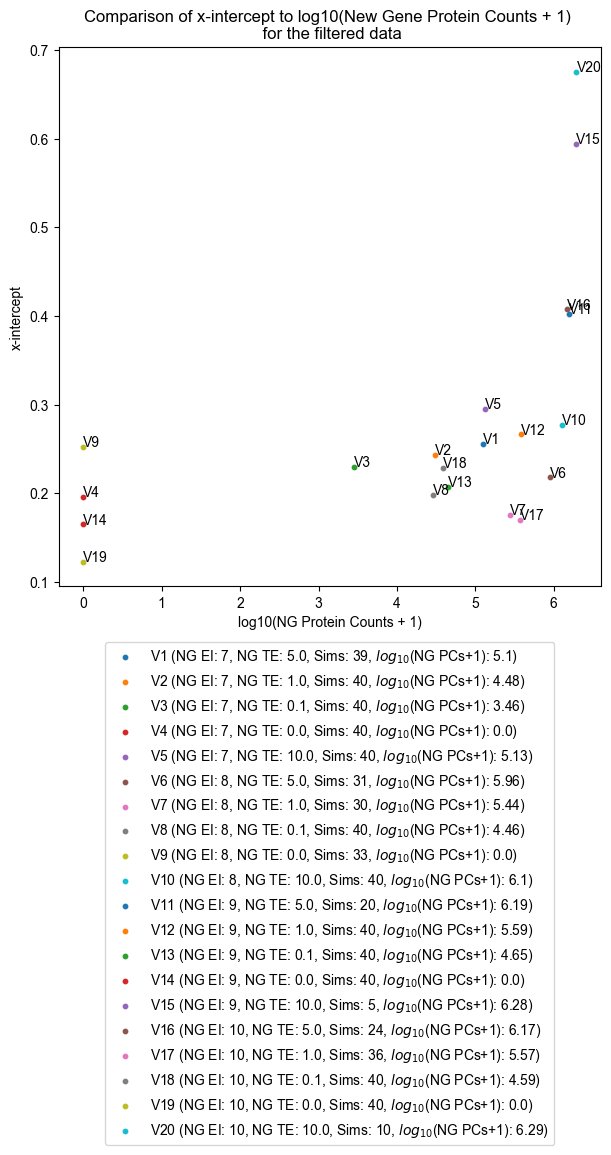

In [4]:
# create a function that plots the data and the linear fit for each variant:
def plot_x_intercept_and_NG_count_log10Filtered(variant_nums):
    plt.figure(figsize=(7, 7))
    
    for i in range(len(variant_nums)):
        var_num = variant_nums[i]
        var_string = get_sim1_var_info(var_num)
        
        # get the linear information:
        df = log10_normalized_data(var_num)
        m, b, x_intercept = get_linear_info_log10Filtered(df)
        
        # get the NG counts for the variant:
        variant = variant_info[var_num:var_num+1]
        log10NGPCs = variant["log(NG PCs +1)"].item()
        
        # plot a scatter point for the x-intercept and the log10(NG counts) and label the point on the graph:
        plt.scatter(log10NGPCs, x_intercept, label = var_string, s = 10)
        plt.text(log10NGPCs, x_intercept, "V"+str(var_num), fontsize=10)
        
    # plotting specs
    plt.ylabel("x-intercept")
    plt.xlabel("log10(NG Protein Counts + 1)")
    plt.title("Comparison of x-intercept to log10(New Gene Protein Counts + 1) \n for the filtered data")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=1)
    plt.show()
    
plot_x_intercept_and_NG_count_log10Filtered([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

# Linear Fit Comparisons sorted by amount of NG in the variant

## Linear Fit comparisons for NG counts = 0

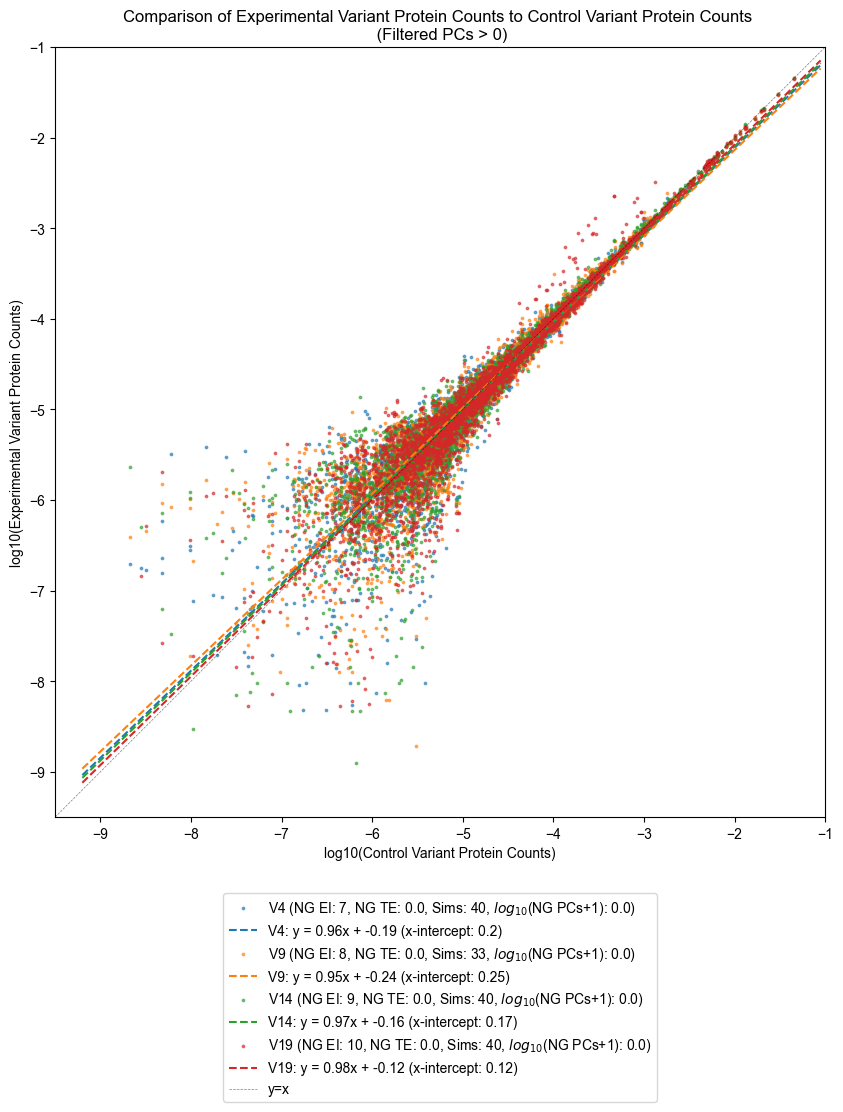

In [5]:
plot_linear_fit_log10Filtered([4,9,14,19], -9.5)


## Linear Fit comparisons for NG counts between 3 and 5

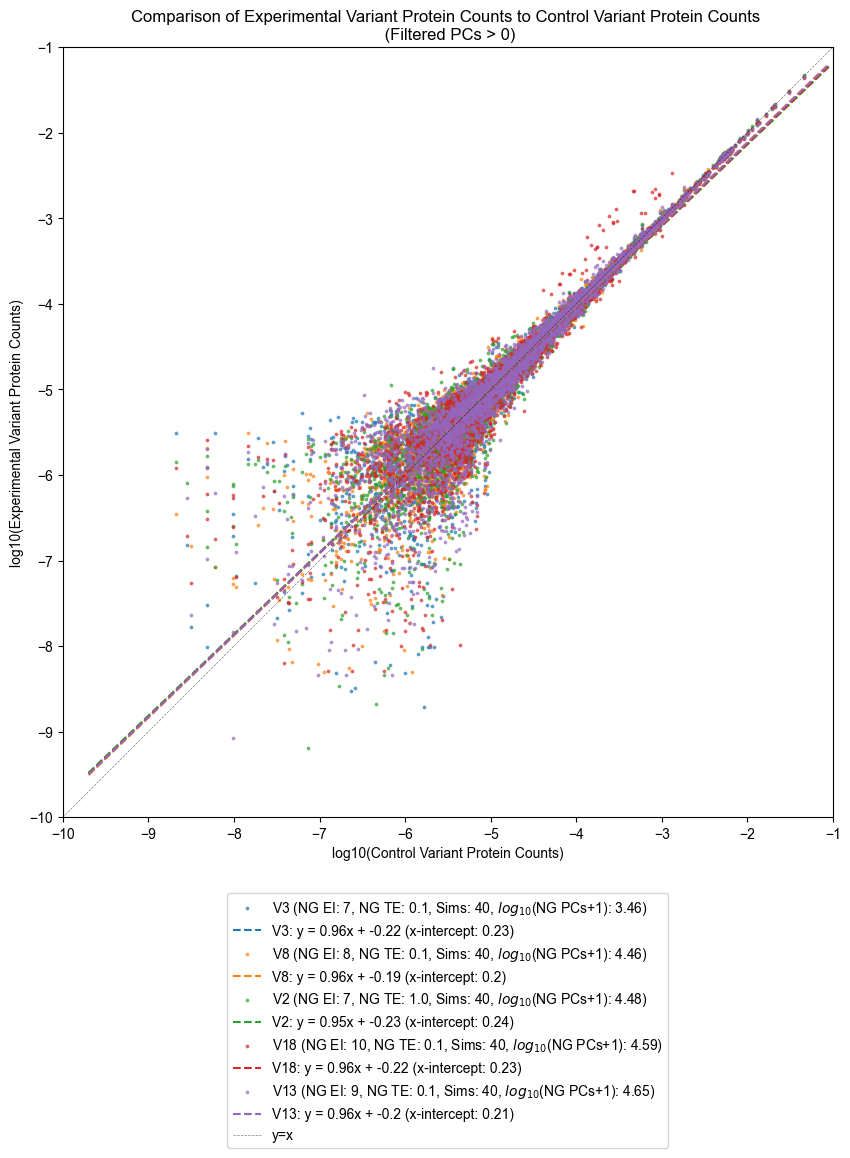

In [6]:
plot_linear_fit_log10Filtered([3,8,2,18,13])

## Linear Fit comparisons for NG counts between 5 and 6

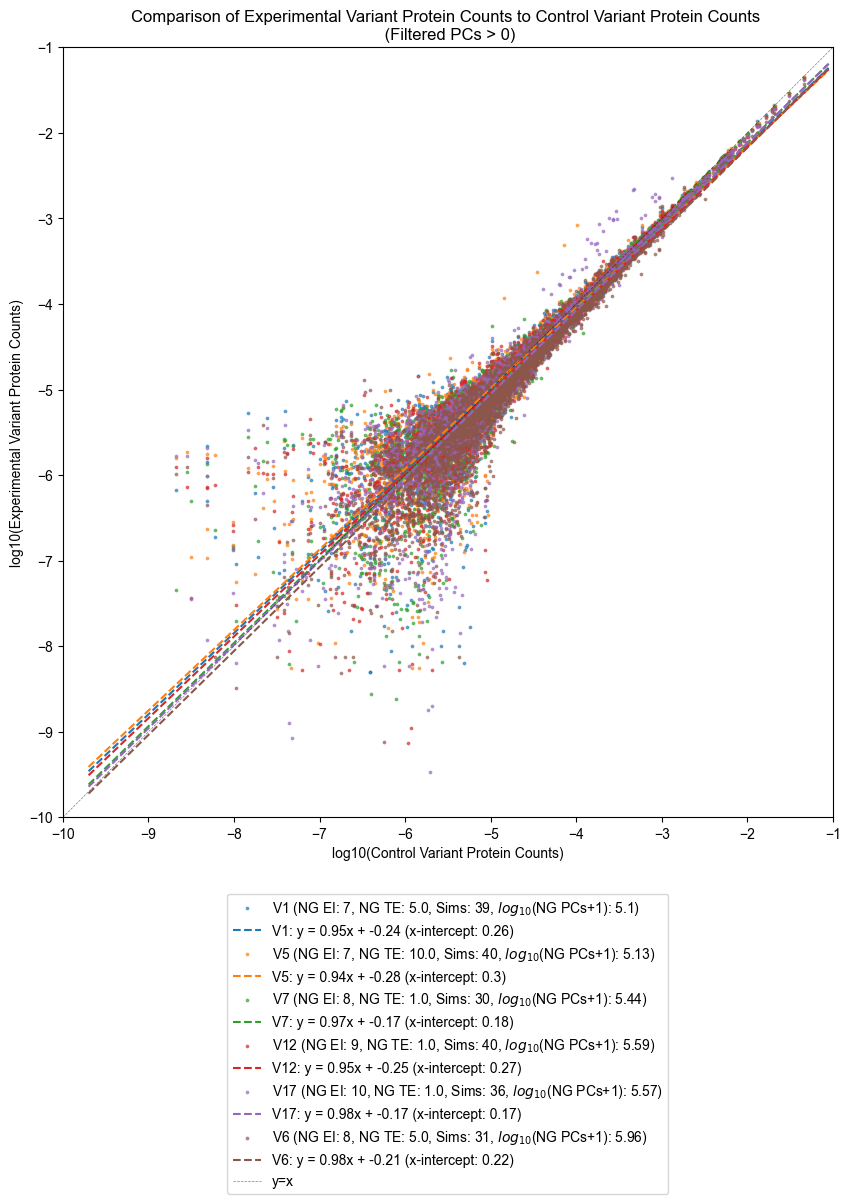

In [7]:
plot_linear_fit_log10Filtered([1,5,7,12,17,6])

# Linear Fit Comparisons for NG counts above 6

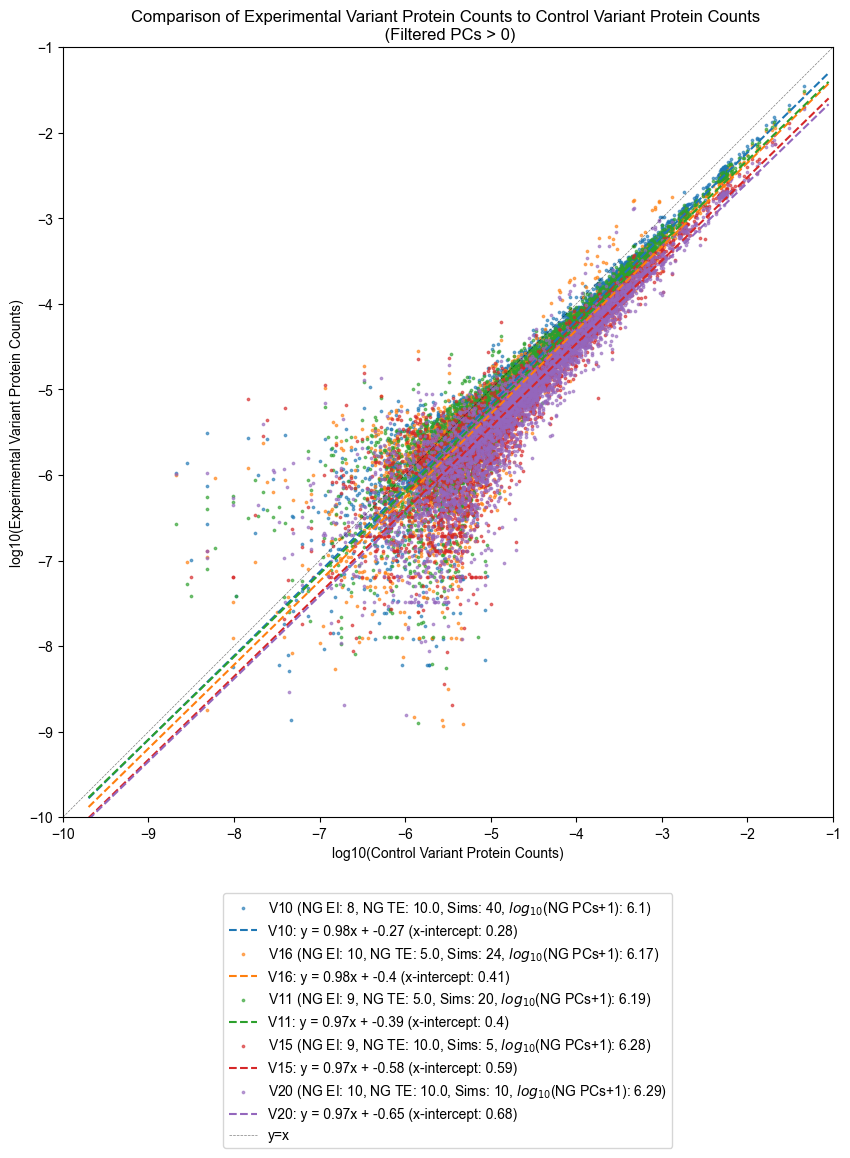

In [8]:
plot_linear_fit_log10Filtered([10,16,11,15,20])

# Linear Fit Comparisons sorted by NG Expression

## Linear Fit comparisons for NG expression = 7

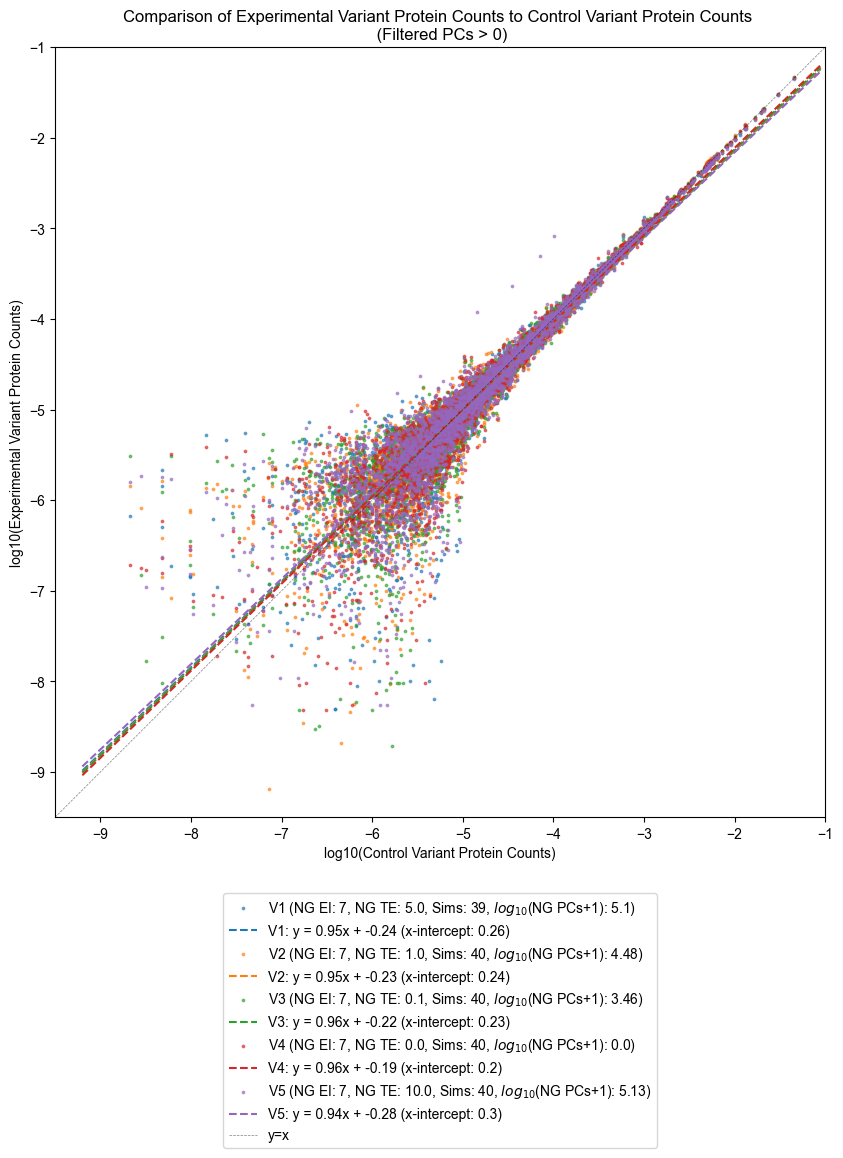

In [9]:
plot_linear_fit_log10Filtered([1,2,3,4,5], -9.5)

## Linear Fit comparisons for NG expression = 8

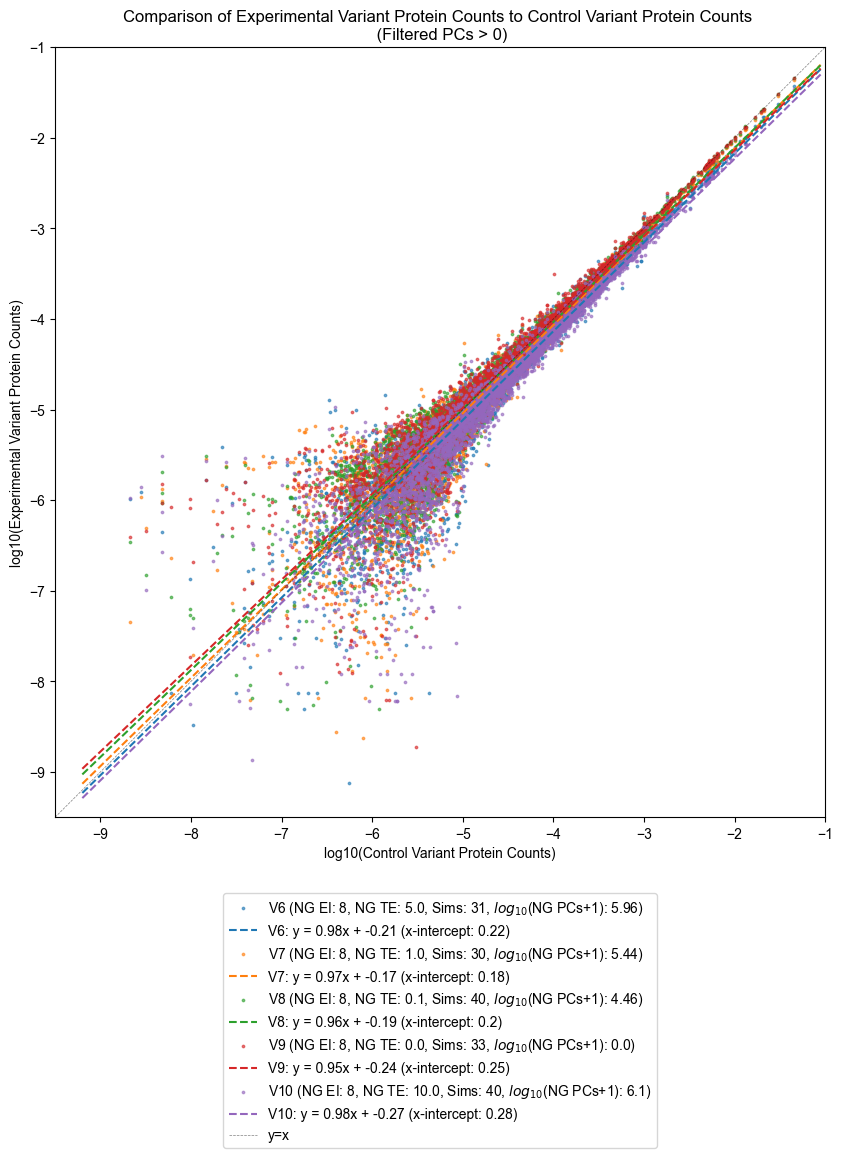

In [10]:
plot_linear_fit_log10Filtered([6,7,8,9,10], -9.5)

## Linear Fit comparisons for NG expression = 9

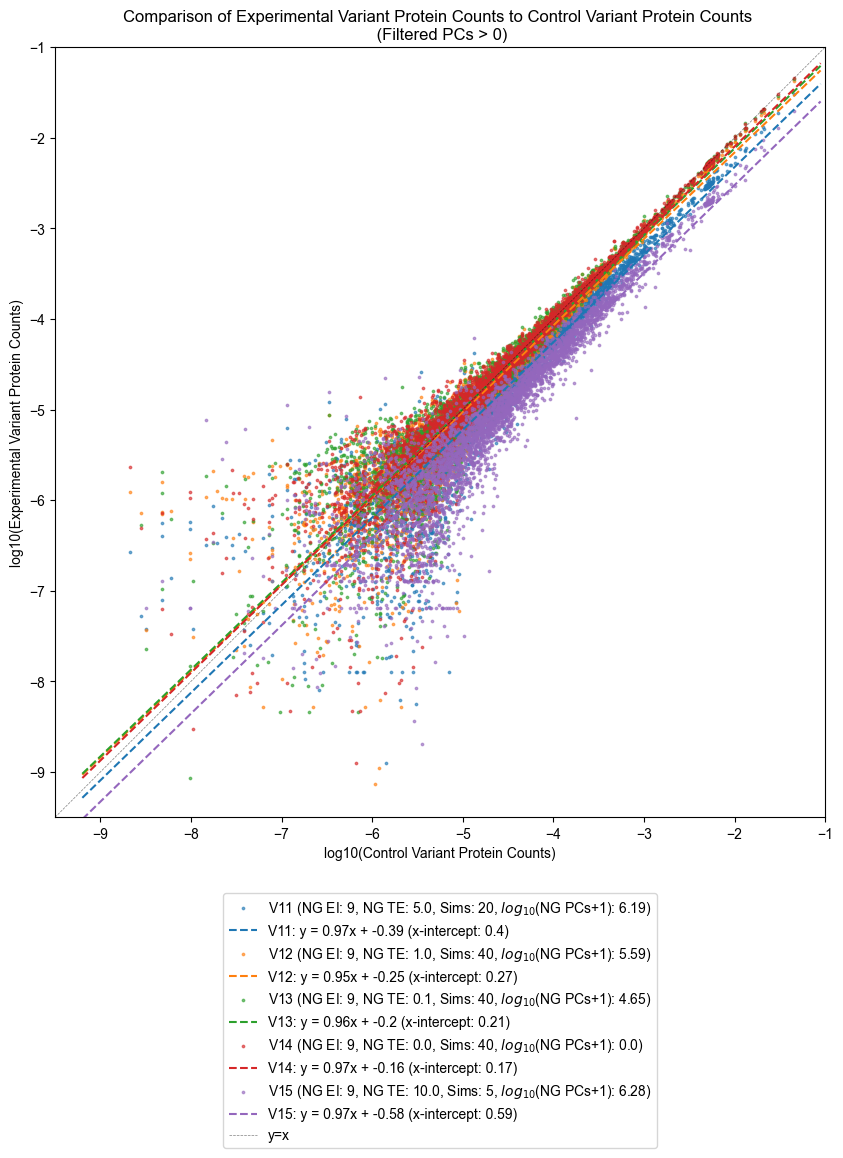

In [11]:
plot_linear_fit_log10Filtered([11,12,13,14,15], -9.5)

## Linear Fit comparisons for NG expression = 10

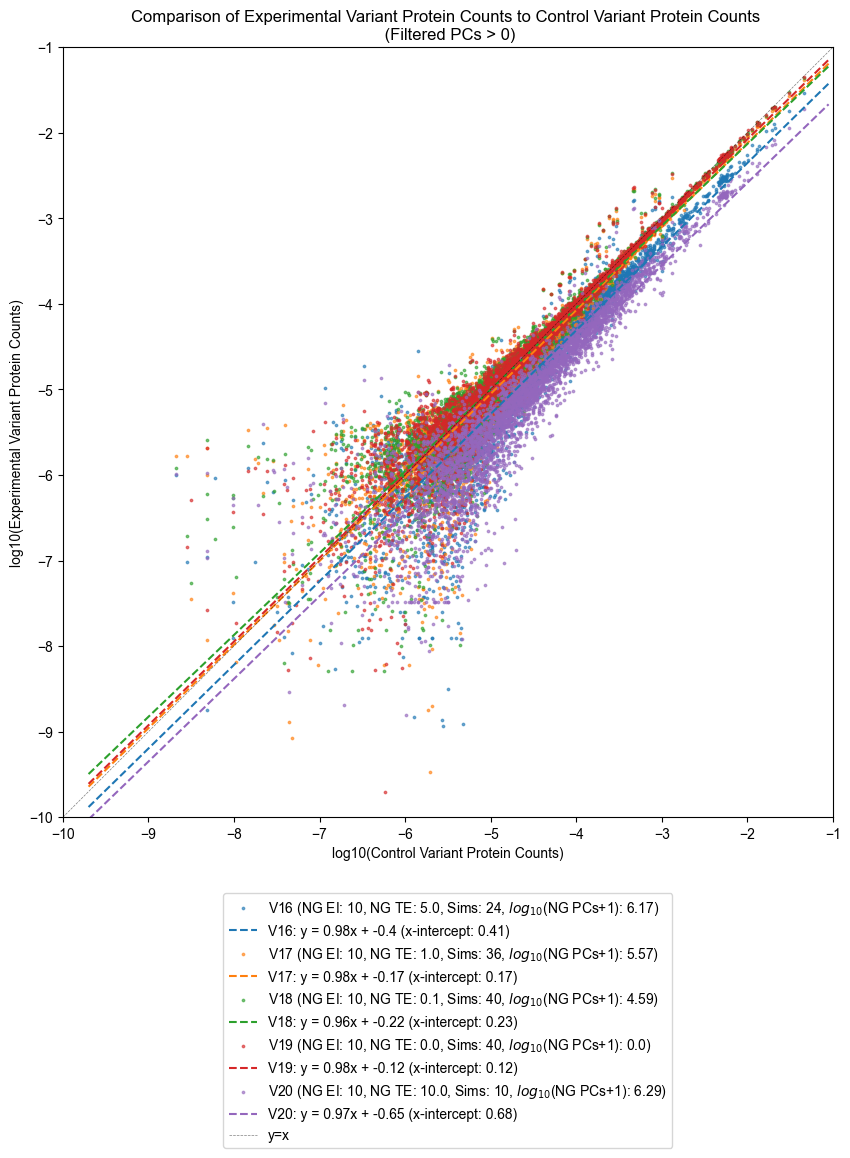

In [12]:
plot_linear_fit_log10Filtered([16,17,18,19,20])

# Translation Efficency Comparisons

## Linear Fit comparisons for TE = 0.0

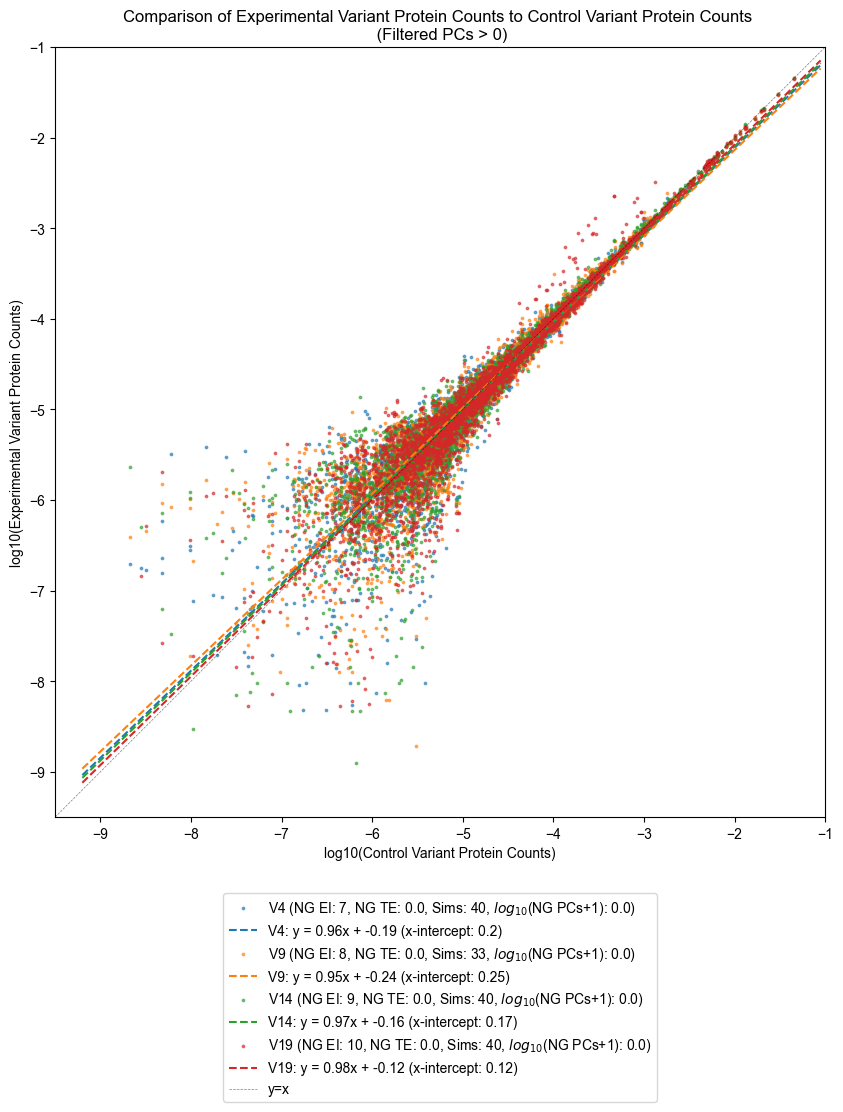

In [13]:
plot_linear_fit_log10Filtered([4,9,14,19], -9.5)
# todo: maybe make the lines a different color or alpha so that its not so hard to differenciate between them and the data points

## Linear Fit comparisons for TE = 0.1

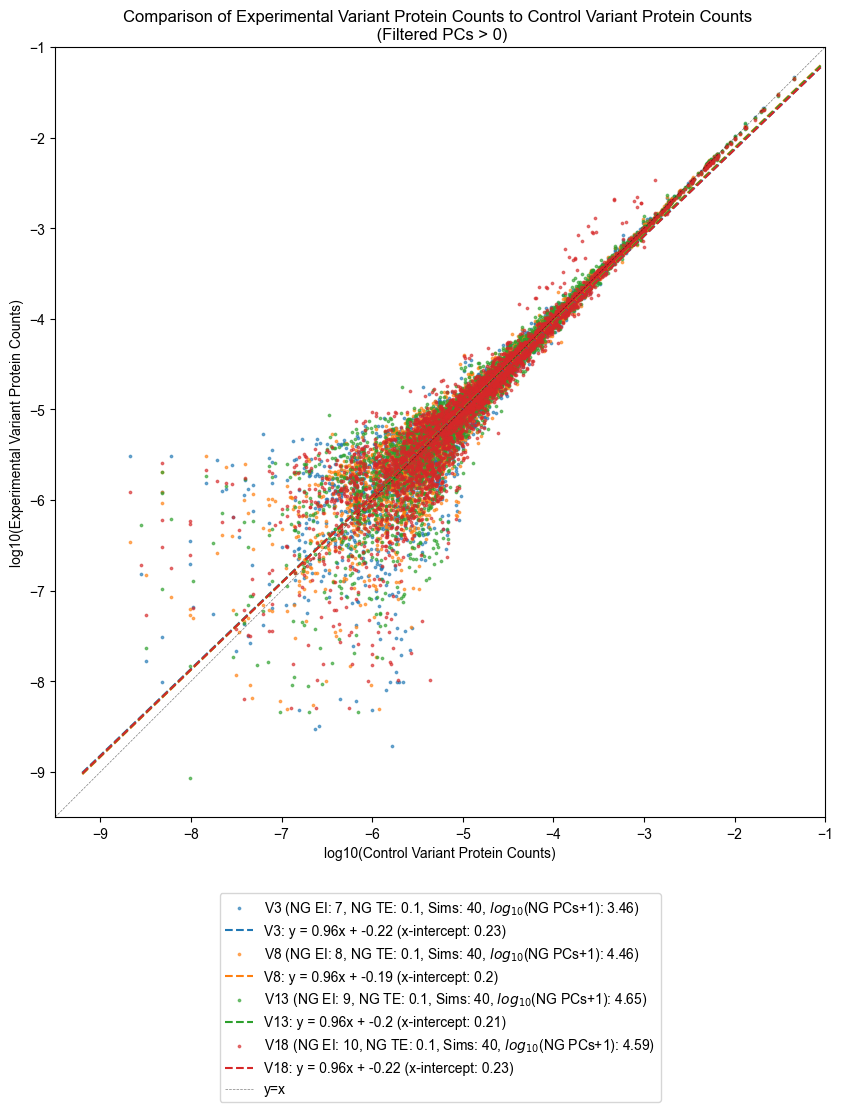

In [14]:
plot_linear_fit_log10Filtered([3,8,13,18], -9.5)

## Linear Fit comparisons for TE = 1

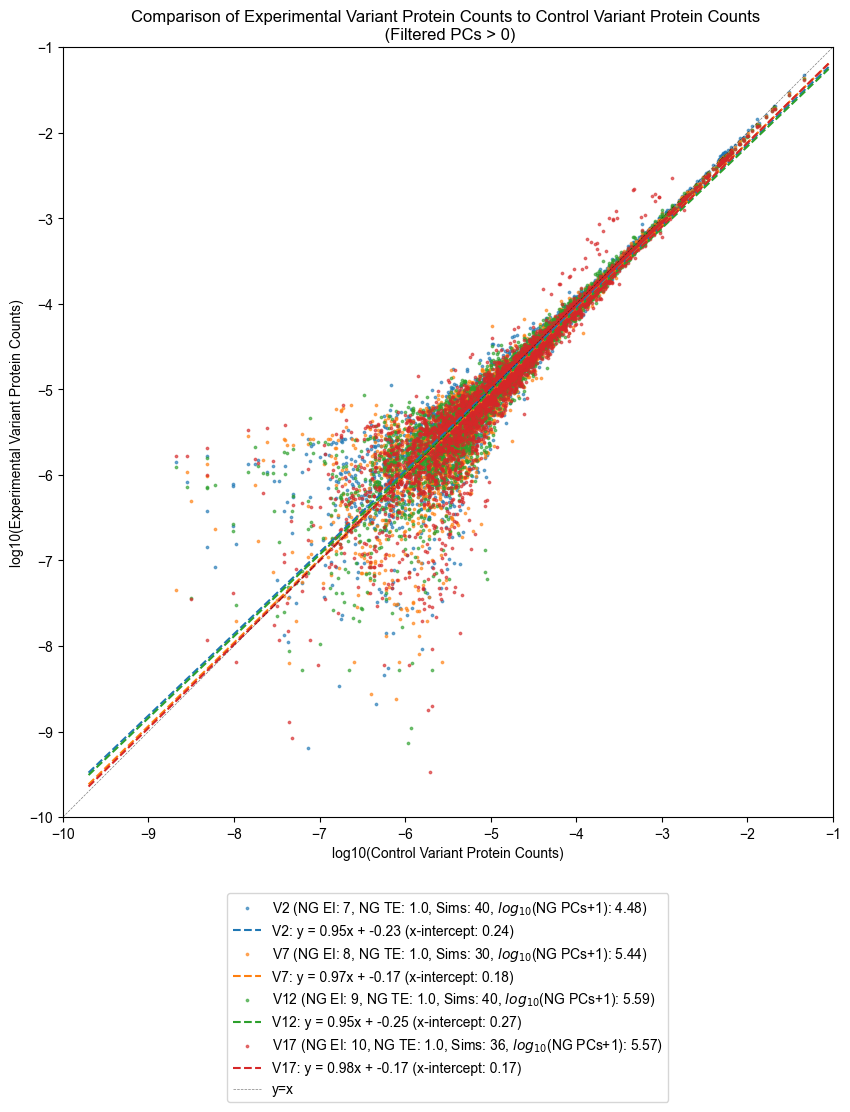

In [15]:
plot_linear_fit_log10Filtered([2,7,12,17])

## Linear Fit comparisons for TE = 5

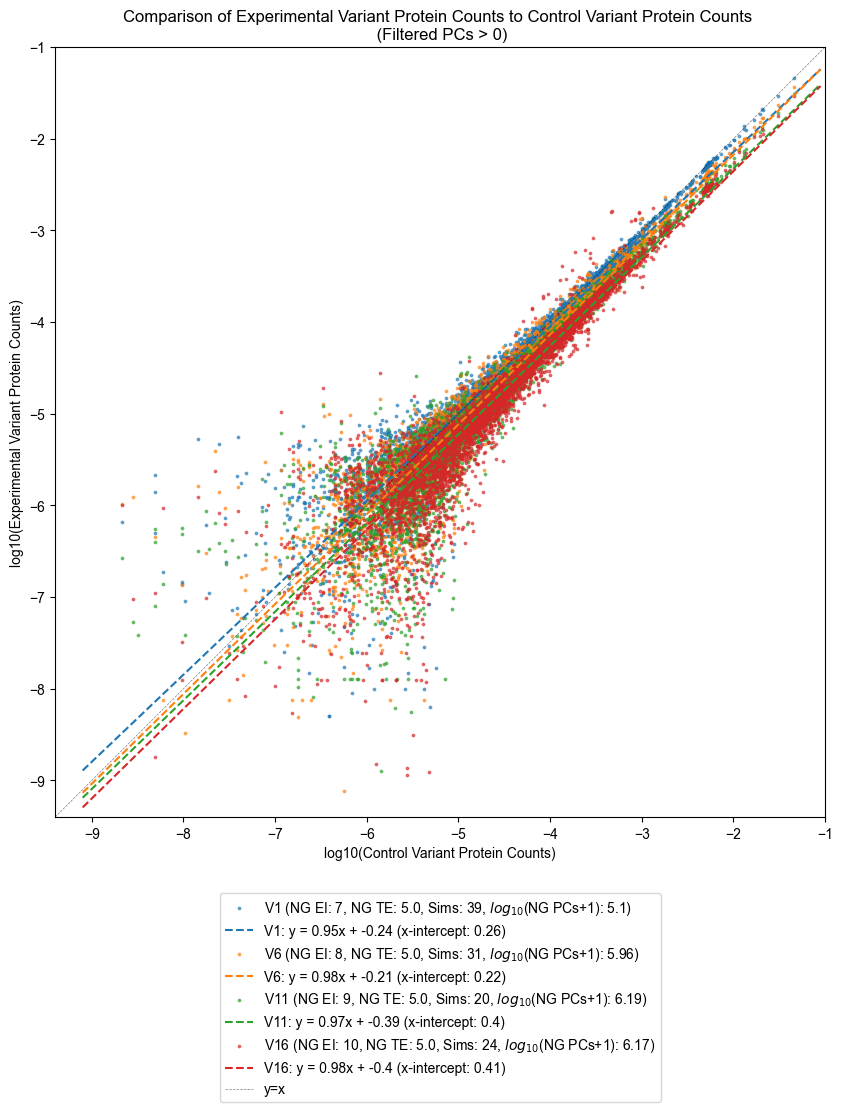

In [16]:
plot_linear_fit_log10Filtered([1,6,11,16], -9.4)

## Linear Fit comparisons for TE = 10

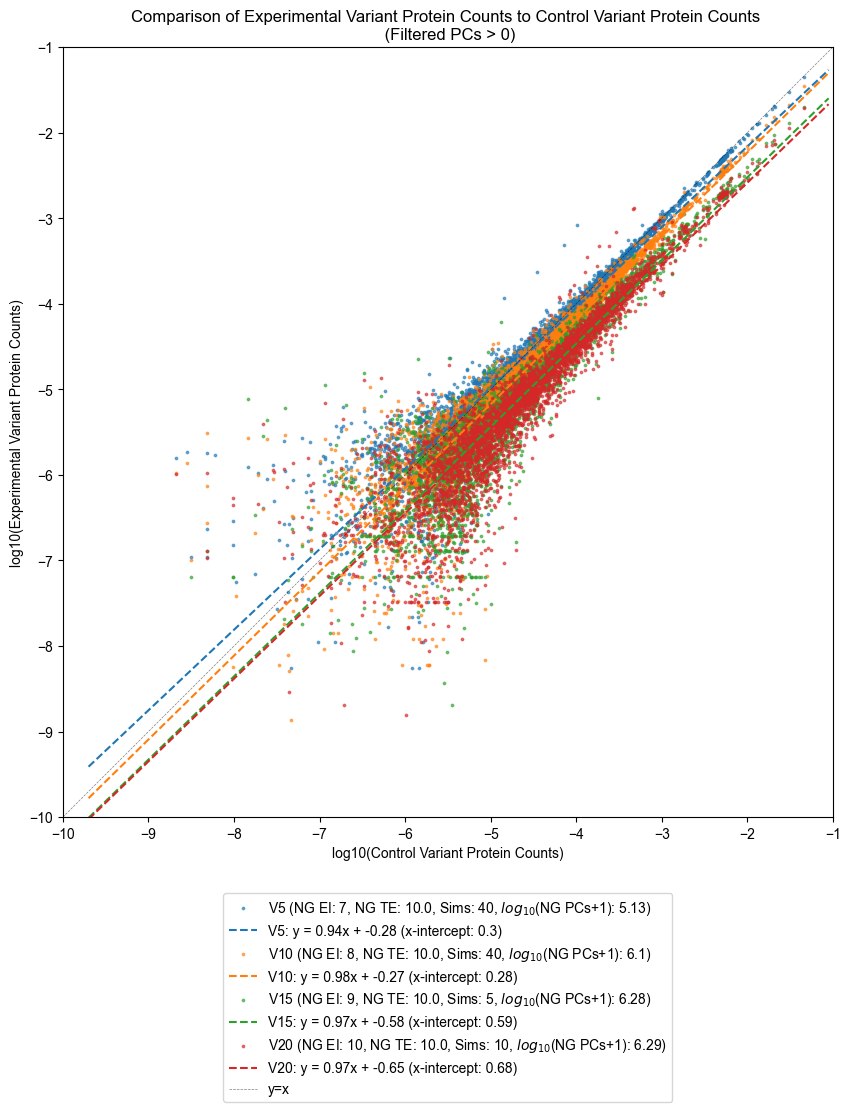

In [17]:
plot_linear_fit_log10Filtered([5,10,15,20])